# CITRA

## library

In [ ]:
!pip install gdown

In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gdown
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

## Ekstrak Dataset

In [ ]:
zip_url = "https://drive.google.com/file/d/1yiYO8RfXBArW0WsSwES_9QFylz_lJ8LM/view?usp=sharing"
zip_id = zip_url.split('/')[-2]
zip_path = "rps.zip"

gdown.download(id=zip_id, output=zip_path, quiet=False)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall("dataset/")

Downloading...
From (original): https://drive.google.com/uc?id=1yiYO8RfXBArW0WsSwES_9QFylz_lJ8LM
From (redirected): https://drive.google.com/uc?id=1yiYO8RfXBArW0WsSwES_9QFylz_lJ8LM&confirm=t&uuid=f028029f-8559-465e-975c-3a45887c9b12
To: /content/rps.zip
100%|██████████| 201M/201M [00:01<00:00, 124MB/s]


## Bagi Dataset

In [ ]:
# Folder tujuan
base_dir = "data/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Buat folder
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

source_dir = "dataset/rps/"
for cls in os.listdir(source_dir):
    for folder in [train_dir, val_dir, test_dir]:
        class_folder = os.path.join(folder, cls)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

# Fungsi membagi dataset
def split_data(source_dir, train_dir, val_dir, test_dir, train_split=0.7, val_split=0.2):
    classes = os.listdir(source_dir)
    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)
        train_size = int(len(images) * train_split)
        val_size = int(len(images) * val_split)

        for i, img in enumerate(images):
            src_path = os.path.join(class_path, img)
            if i < train_size:
                shutil.copy(src_path, os.path.join(train_dir, cls))
            elif i < train_size + val_size:
                shutil.copy(src_path, os.path.join(val_dir, cls))
            else:
                shutil.copy(src_path, os.path.join(test_dir, cls))

# Eksekusi split
split_data(source_dir, train_dir, val_dir, test_dir)

## EDA

In [ ]:
# Fungsi untuk menganalisis distribusi kelas
def analyze_distribution(folder):
    class_counts = {cls: len(os.listdir(os.path.join(folder, cls)))
                    for cls in os.listdir(folder)}
    return class_counts

In [ ]:
# Fungsi untuk menampilkan beberapa gambar contoh dari setiap kelas
def display_sample_images(folder, num_images=5):
    classes = os.listdir(folder)
    for cls in classes:
        class_path = os.path.join(folder, cls)
        images = os.listdir(class_path)
        random_images = np.random.choice(images, num_images, replace=False)

        plt.figure(figsize=(10, 5))
        for i, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.show()

In [ ]:
# Analisis distribusi kelas pada data latih, validasi, dan uji
train_dist = analyze_distribution(train_dir)
val_dist = analyze_distribution(val_dir)
test_dist = analyze_distribution(test_dir)

print("Distribusi Kelas (Latih):", train_dist)
print("Distribusi Kelas (Validasi):", val_dist)
print("Distribusi Kelas (Uji):", test_dist)

Distribusi Kelas (Latih): {'rock': 588, 'paper': 588, 'scissors': 588}
Distribusi Kelas (Validasi): {'rock': 168, 'paper': 168, 'scissors': 168}
Distribusi Kelas (Uji): {'rock': 84, 'paper': 84, 'scissors': 84}


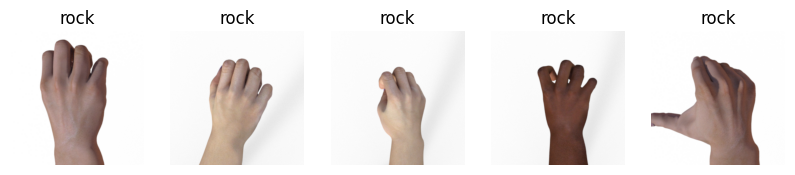

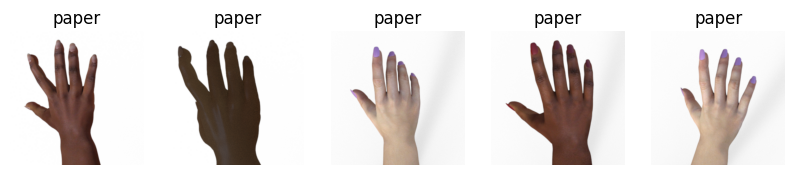

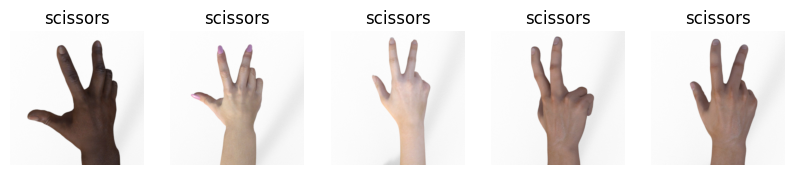

In [ ]:
# Tampilkan beberapa gambar contoh dari setiap kelas pada data latih
display_sample_images(train_dir)

## Preprocessing dan Data Augmentation

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
val_data = val_gen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

Found 1764 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 252 images belonging to 3 classes.


## Transfer Learning dengan ResNet50

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Tambahkan layer kustom
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_data.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Bekukan layer pre-trained
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Latih Model

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.3739 - loss: 2.2163 - val_accuracy: 0.5020 - val_loss: 0.9997
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.4293 - loss: 1.0465 - val_accuracy: 0.5774 - val_loss: 0.9237
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.4795 - loss: 0.9881 - val_accuracy: 0.6052 - val_loss: 0.8734
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.4962 - loss: 0.9623 - val_accuracy: 0.6587 - val_loss: 0.7974
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.4779 - loss: 0.9159 - val_accuracy: 0.6032 - val_loss: 0.7470
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5098 - loss: 0.8828 - val_accuracy: 0.6548 - val_loss: 0.7253
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.5356 - loss: 0.8546 - val_accuracy: 0.6468 - val_loss: 0.6778
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5764 - loss: 0.8273 - val_accuracy: 0.7004 - val_loss: 0.

## Evaluasi Model

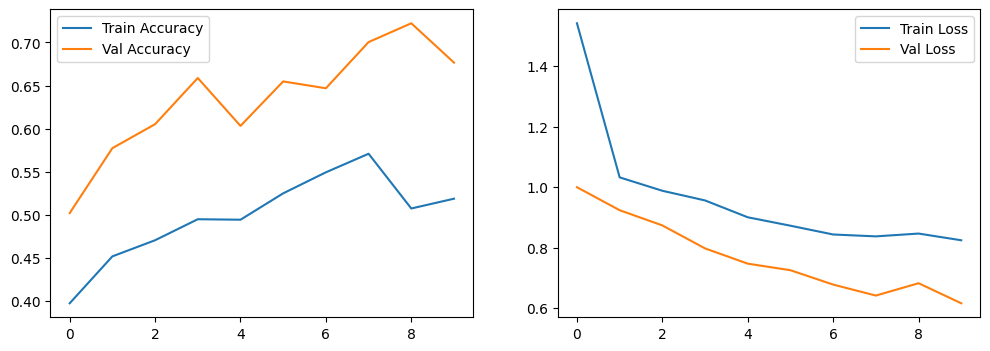

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step
              precision    recall  f1-score   support

       paper       0.34      0.55      0.42        84
        rock       0.32      0.37      0.34        84
    scissors       0.30      0.07      0.12        84

    accuracy                           0.33       252
   macro avg       0.32      0.33      0.29       252
weighted avg       0.32      0.33      0.29       252



In [ ]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

plt.show()

# Classification report
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

## Prediksi pada 10 Gambar Acak

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


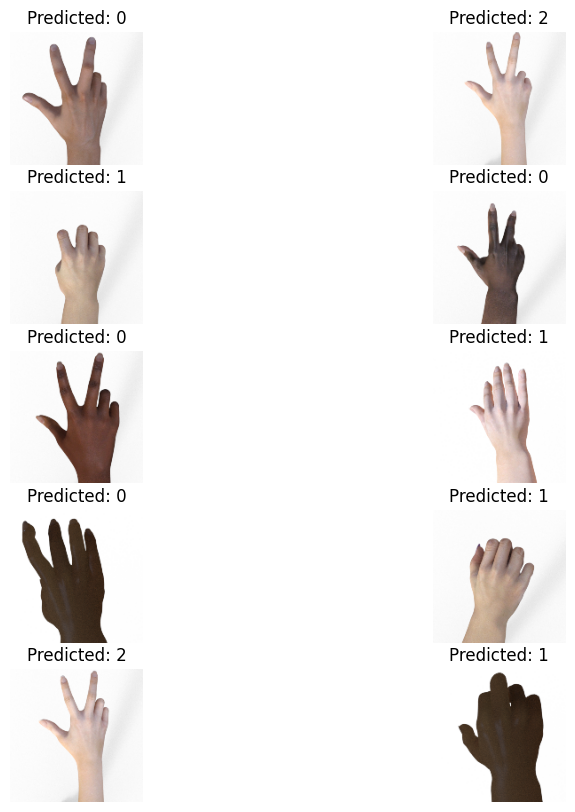

In [ ]:
test_images, test_labels = next(test_data)
predictions = model.predict(test_images[:10])

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()